<a href="https://colab.research.google.com/github/ooke22/EPL-Clustering-/blob/main/EPL_Clustering_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

#importing PCA and TSNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv(r'/content/drive/MyDrive/Unsupervised Learning Practice/fpl_data.csv')
df.sample(10, random_state=1)

,Player_Name,Club,Position,Goals_Scored,Assists,Total_Points,Minutes,Goals_Conceded,Creativity,Influence,Threat,Bonus,Clean_Sheets
441,Mark Noble,West Ham United,Midfielder,0,0,27,701,15,88.6,80.4,7,0,0
363,Sean Longstaff,Newcastle United,Midfielder,0,1,41,1405,26,182.8,179.2,148,1,2
31,Anwar El Ghazi,Aston Villa,Midfielder,10,0,111,1604,22,426.1,500.4,726,13,5
132,Olivier Giroud,Chelsea,Forward,4,0,47,740,5,112.0,161.4,403,6,4
90,Chris Wood,Burnley,Forward,12,3,138,2741,43,323.2,595.8,1129,16,9
249,Vontae Daley-Campbell,Leicester City,Defender,0,0,0,0,0,0.0,0.0,0,0,0
65,Danny Welbeck,Brighton and Hove Albion,Forward,6,4,89,1541,18,269.7,319.8,595,15,6
445,Ryan Fredericks,West Ham United,Defender,1,1,28,564,9,166.8,155.2,96,0,1
117,Christian Pulisic,Chelsea,Midfielder,4,3,82,1731,21,378.8,361.4,724,3,7
415,Ryan Sessegnon,Tottenham Hotspurs,Defender,0,0,0,0,0,0.0,0.0,0,0,0


In [ ]:
df.info()
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Player_Name     476 non-null    object 
 1   Club            476 non-null    object 
 2   Position        476 non-null    object 
 3   Goals_Scored    476 non-null    int64  
 4   Assists         476 non-null    int64  
 5   Total_Points    476 non-null    int64  
 6   Minutes         476 non-null    int64  
 7   Goals_Conceded  476 non-null    int64  
 8   Creativity      476 non-null    float64
 9   Influence       476 non-null    float64
 10  Threat          476 non-null    int64  
 11  Bonus           476 non-null    int64  
 12  Clean_Sheets    476 non-null    int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 48.5+ KB
(476, 13)


### Observation:
* There are no missing values within the dataset.
* There are 476 observations and 13 columns.
* All columns except for player name, Club, and Position are numerical values.

In [ ]:
df.duplicated().sum()

0

### Observation:
* This dataset has 0 duplicated values.

## Exploratory Analysis

In [ ]:
df.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Player_Name,476,476,Alex Runnarsson,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Club,476,17,Arsenal,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Position,476,4,Midfielder,195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Goals_Scored,476.0,NaN,NaN,NaN,1.907563,3.455562,0.0,0.0,0.5,2.0,23.0
Assists,476.0,NaN,NaN,NaN,1.752101,2.708563,0.0,0.0,0.0,2.0,14.0
Total_Points,476.0,NaN,NaN,NaN,58.516807,51.293559,0.0,10.0,48.0,94.25,244.0
Minutes,476.0,NaN,NaN,NaN,1336.909664,1073.773995,0.0,268.75,1269.5,2256.25,3420.0
Goals_Conceded,476.0,NaN,NaN,NaN,19.157563,15.946171,0.0,4.0,18.0,31.0,68.0
Creativity,476.0,NaN,NaN,NaN,195.97605,251.478541,0.0,8.3,96.95,296.95,1414.9
Influence,476.0,NaN,NaN,NaN,294.617647,267.779681,0.0,46.5,233.1,499.5,1318.2


### Observation:
* There are more midfielders compared to the other 3 positions.
* The average total fantasy points scored by a player in the previous season is 58.51.
* The average number of minutes played is ~1340.
* There are 17 different clubs and 476 players within the dataset.
* 25% of the players in the dataset scored at least 2 goals or more.
* The maximum goal scored in a season is 23.

#### Univarate Analysis

In [ ]:
# Write the code here
#Numerical variables
def hist_boxplot(feature, figsize=(15,10), bins="auto"):
  f, (ax_box, ax_hist) = plt.subplots(
      nrows = 2,
      sharex = True,
      gridspec_kw={"height_ratios": (.25, .75)},
      figsize = figsize
  )

  #Box plot
  sns.boxplot(x = feature, ax = ax_box, showmeans =True, color = 'red')

  #Hist
  sns.histplot(x = feature, kde = False, ax = ax_hist, bins = bins)
  ax_hist.axvline(np.mean(feature), color = 'g', linestyle = '--')
  ax_hist.axvline(np.median(feature), color = 'black', linestyle = '-')

  plt.show()

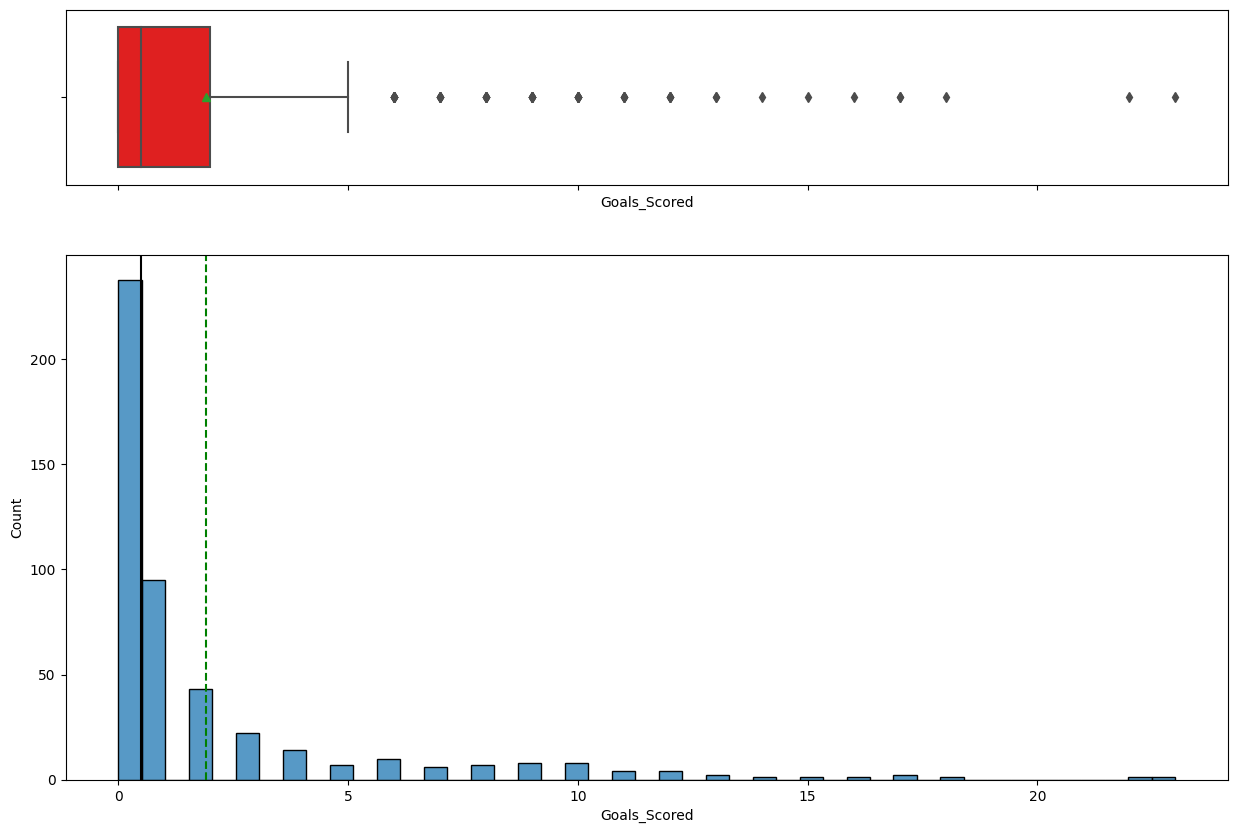

In [ ]:
hist_boxplot(df.Goals_Scored)

### Observation:
* The distribution of goals scored is right skewed.
* The majority of players didn't score a goal.
* The average player within the dataset scored between 0-1 goals while the mean number of goals scored is 2.
* This means about half of the players within the dataset didn't score a goal during the previous season.
* Players who scored above 5 goals are considered outliers.

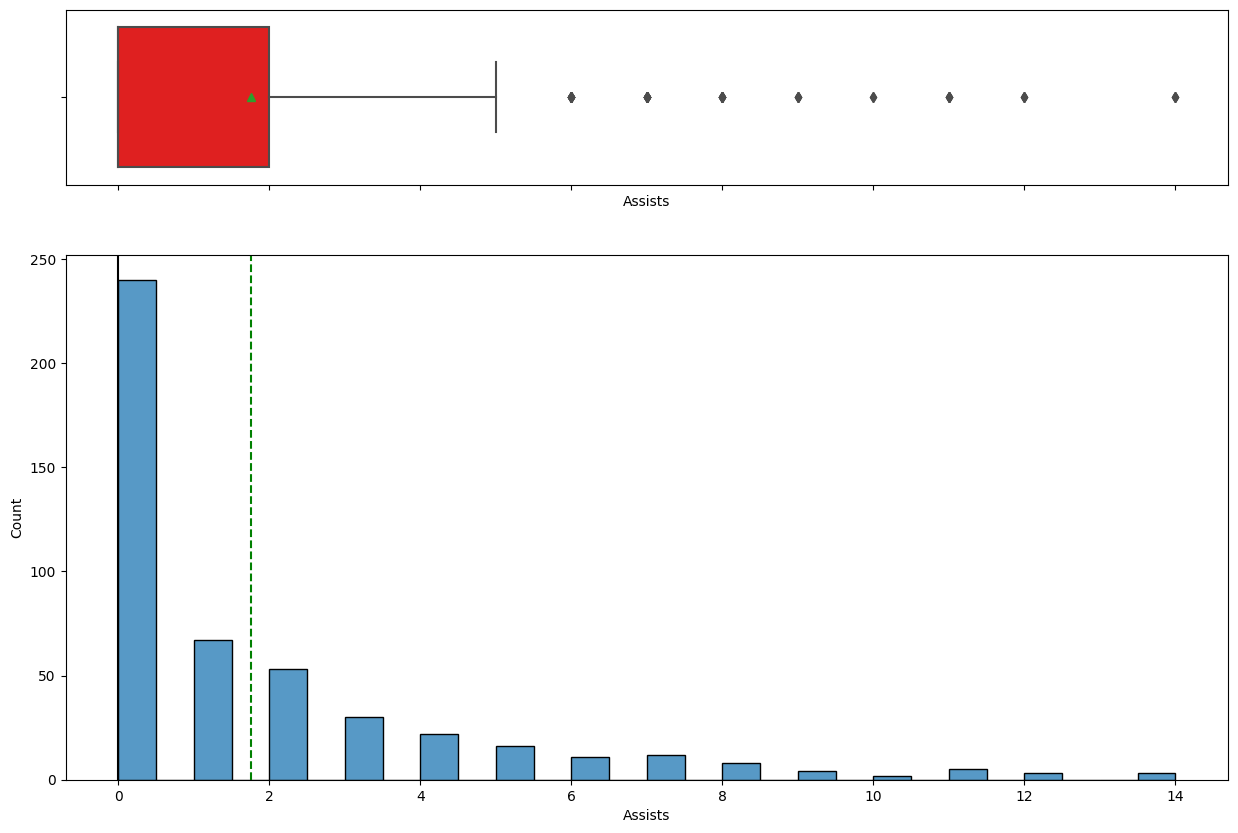

In [ ]:
hist_boxplot(df.Assists)

### Observation:
* The distributionn for assists is right skewed.
* The average player registerd 0 assists during the season, while the mean number of assists is ~2.
* Only 25% of players registered 2 assists or more.
* Players who regsitered 6 assists or more are considered outliers.

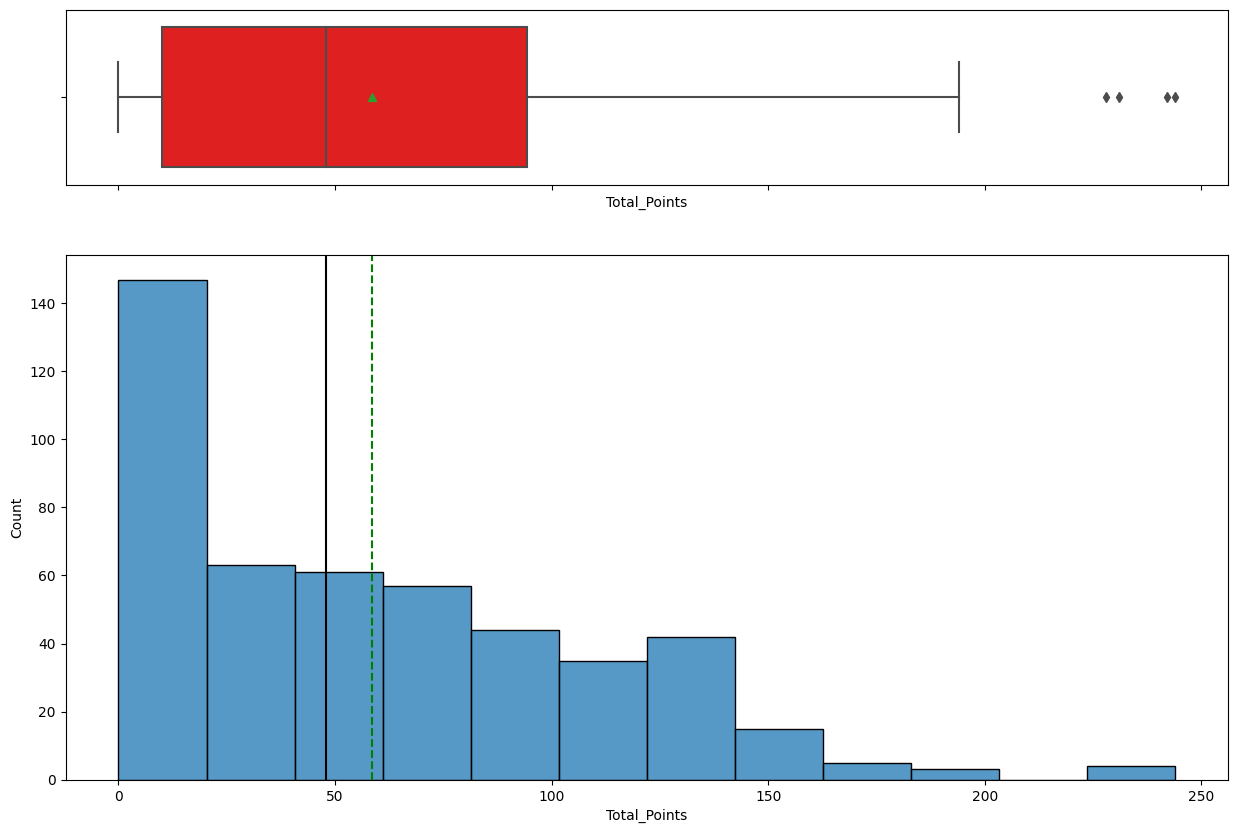

In [ ]:
hist_boxplot(df.Total_Points)

### Observation:
* The distribution for Total Fantasy Points from the previous season is right skewed.
* The average player's total points is 48 while the mean total points is ~ 60. Therefore more than 50% of the players have scored more than 50 fantasy points.
* A large majority of players received total points between 0 and 10.
* Player with total points of 0 did not play a single game during the season.
* 25%  of players have total points above 94.

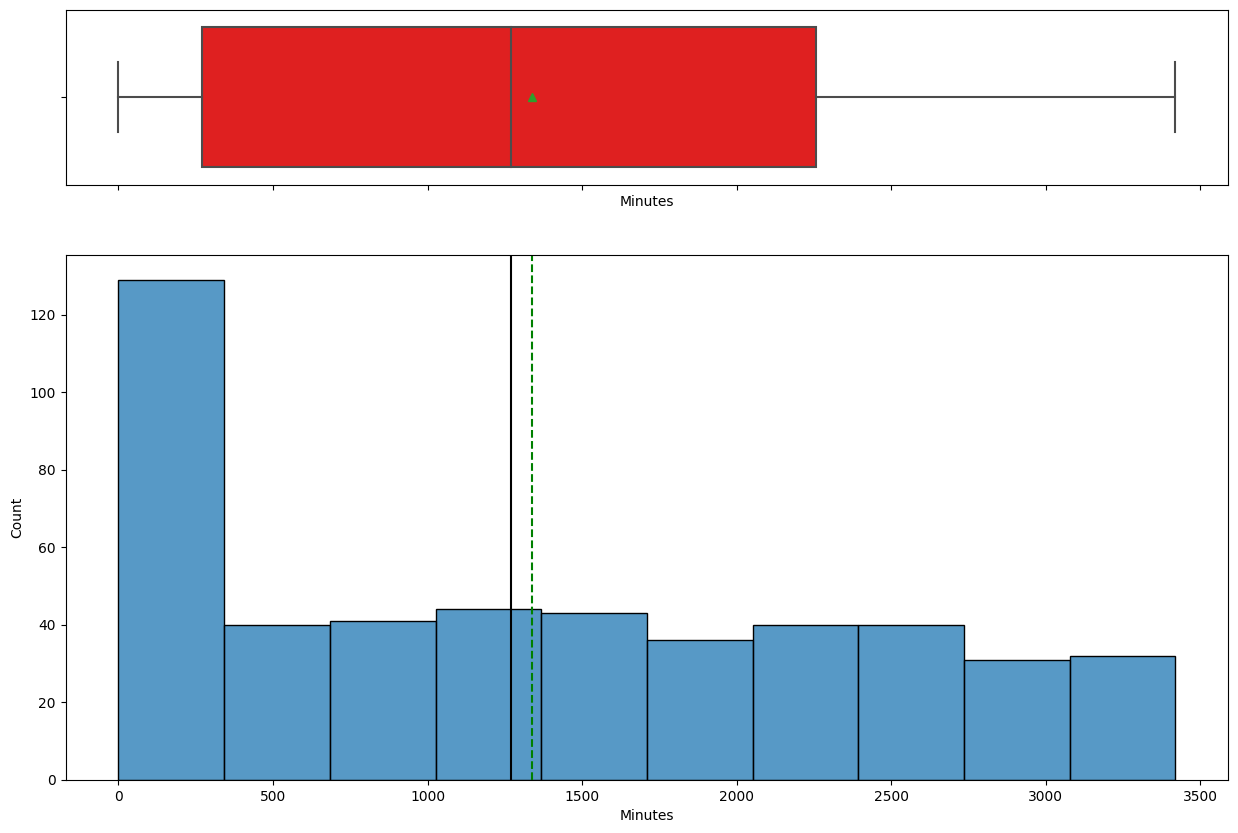

In [ ]:
hist_boxplot(df.Minutes)

### Observation:
* The distribution for minutes looks close to uniform.
* The average player played a total of ~1270 minutes while the mean playing time is 1340 minutes per player.
* Many players did not play even a single minute of football.
* There are a few players who have played significantly more minutes than the majority.

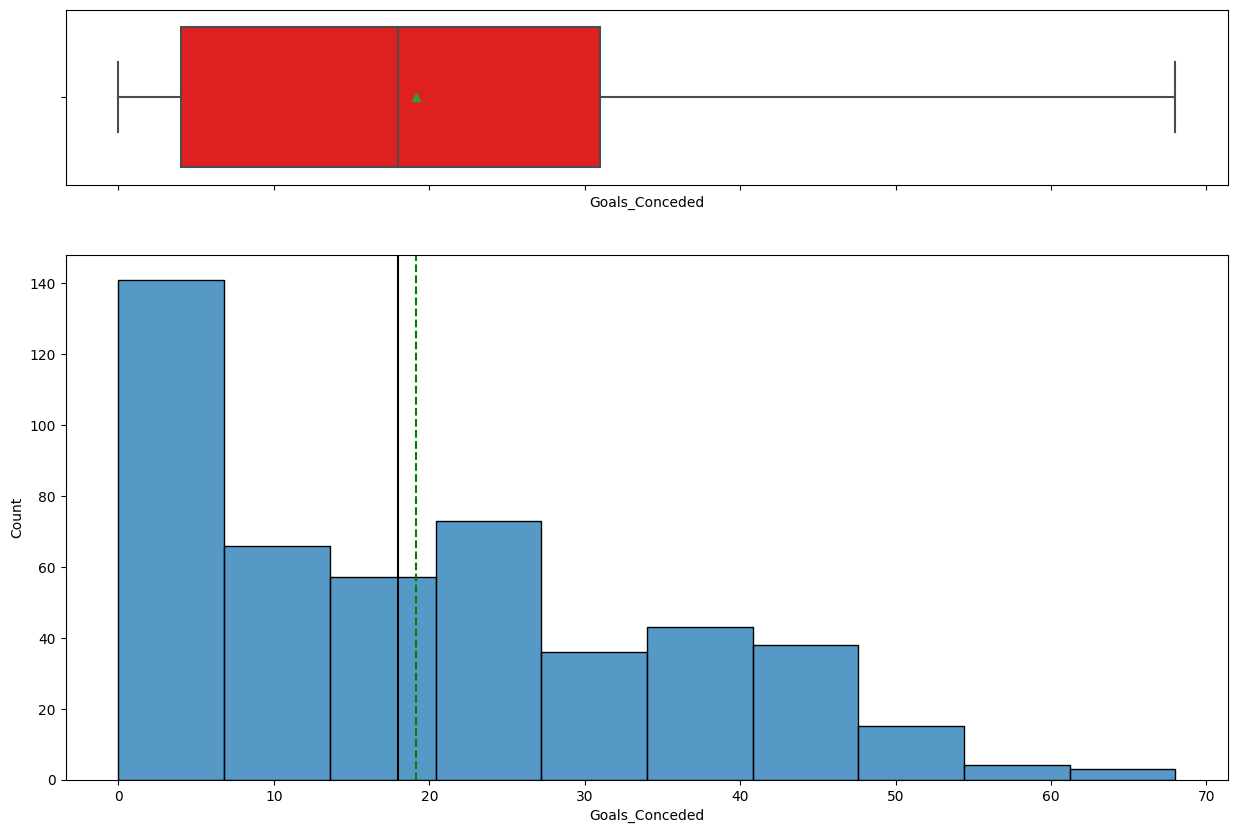

In [ ]:
hist_boxplot(df.Goals_Conceded)

### Observation:
* The distribution for Goals conceded is slightly rignt-skewed.
* Majority of players conceded between 0-5 goals.
* 25% of players conceded 30 goals and above.
* The median (18) and the mean (19) for goals scored are close in distance.
* ~50% of players have conceeded 20 or less goals.

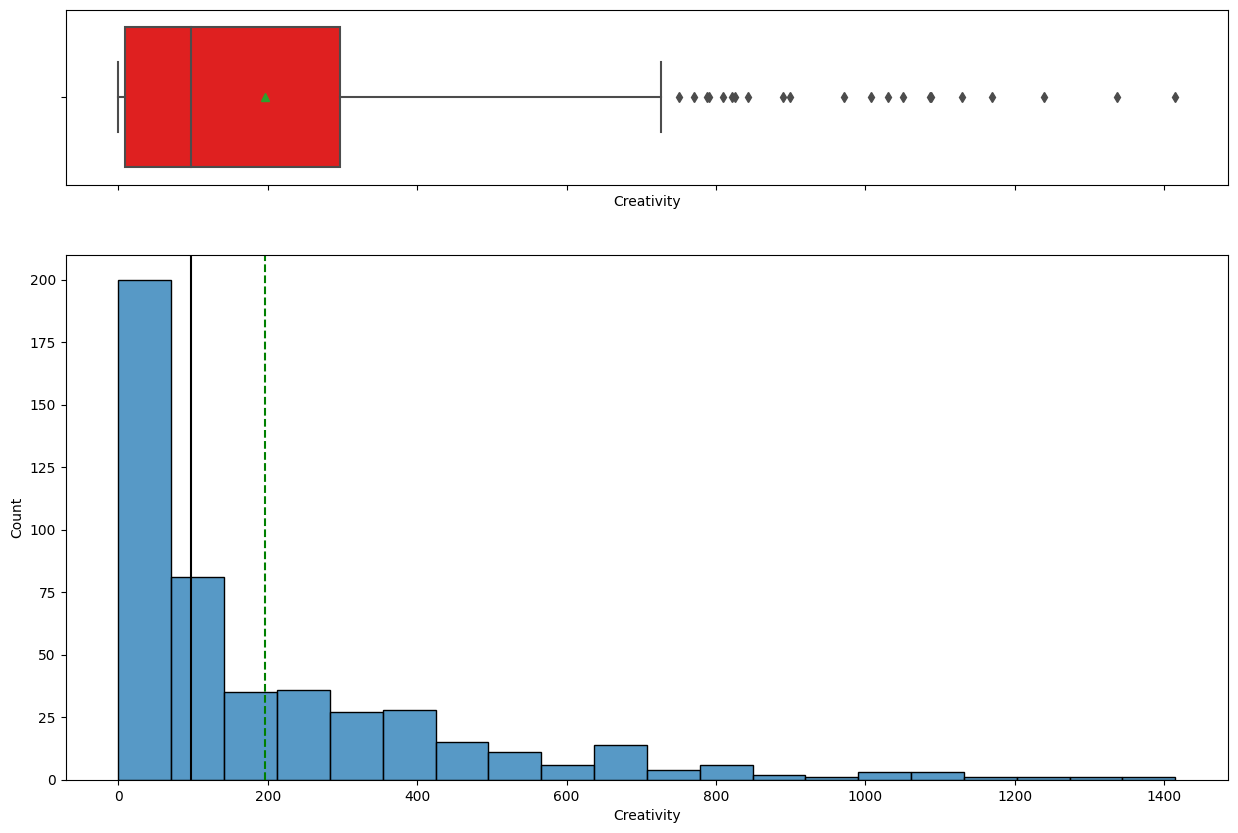

In [ ]:
hist_boxplot(df.Creativity)

### Observation:
* The distrbtution for creativity is right-skewed.
* Very few players have a creativity above 800.
* Majority of players have a creativity between ~ 0-80.

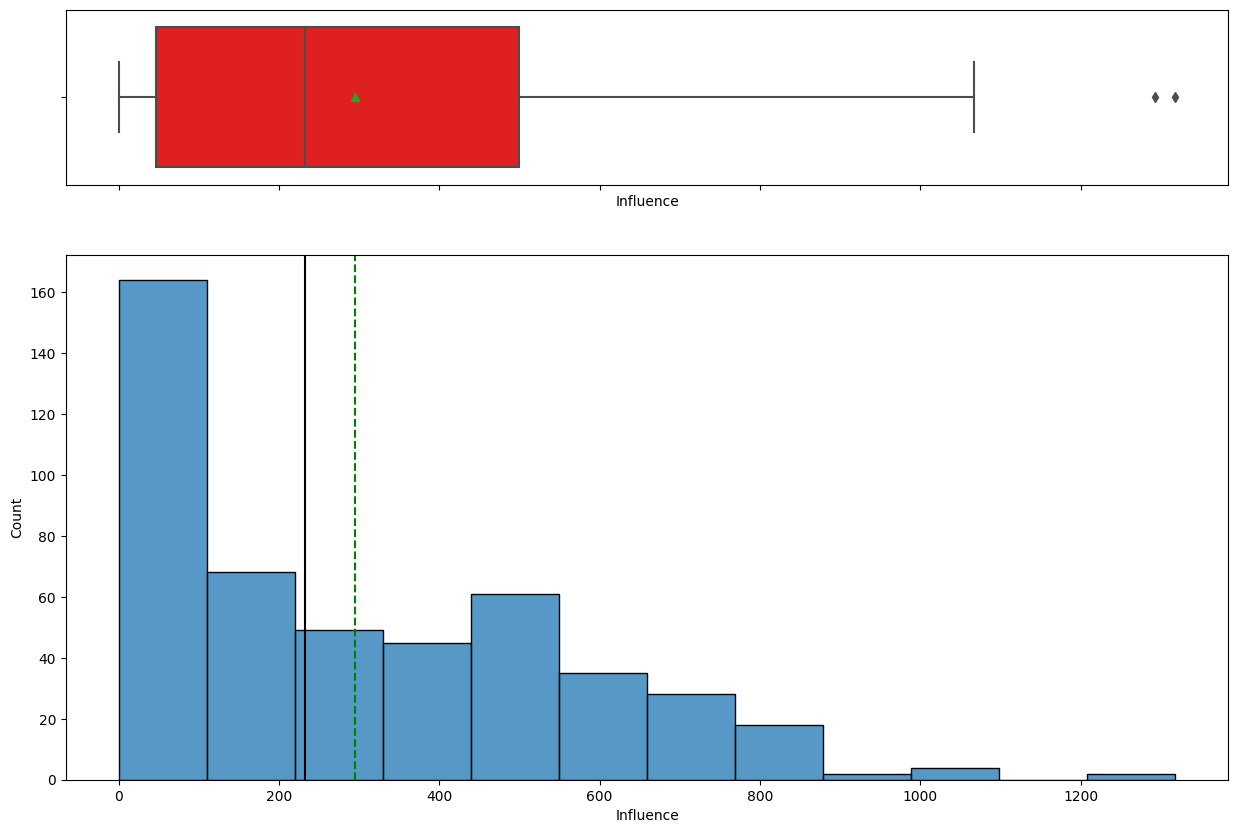

In [ ]:
hist_boxplot(df.Influence)

### Observation:
* The distribution is right-skewed.
* Few players have an influence score of more than 800.

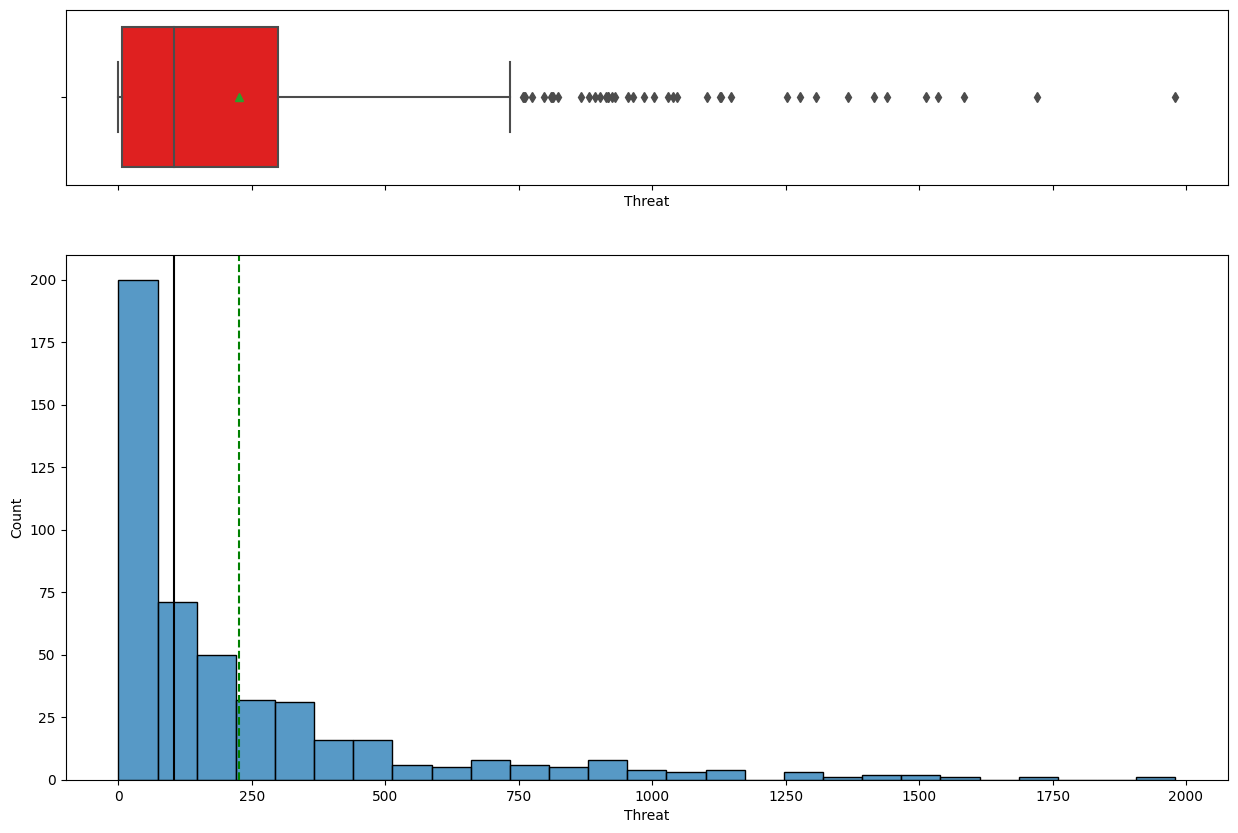

In [ ]:
hist_boxplot(df.Threat)

### Observation:
* The distribution for threat is right-skewed with mutiple outliers.
* Few players have a threat score of more than 500.

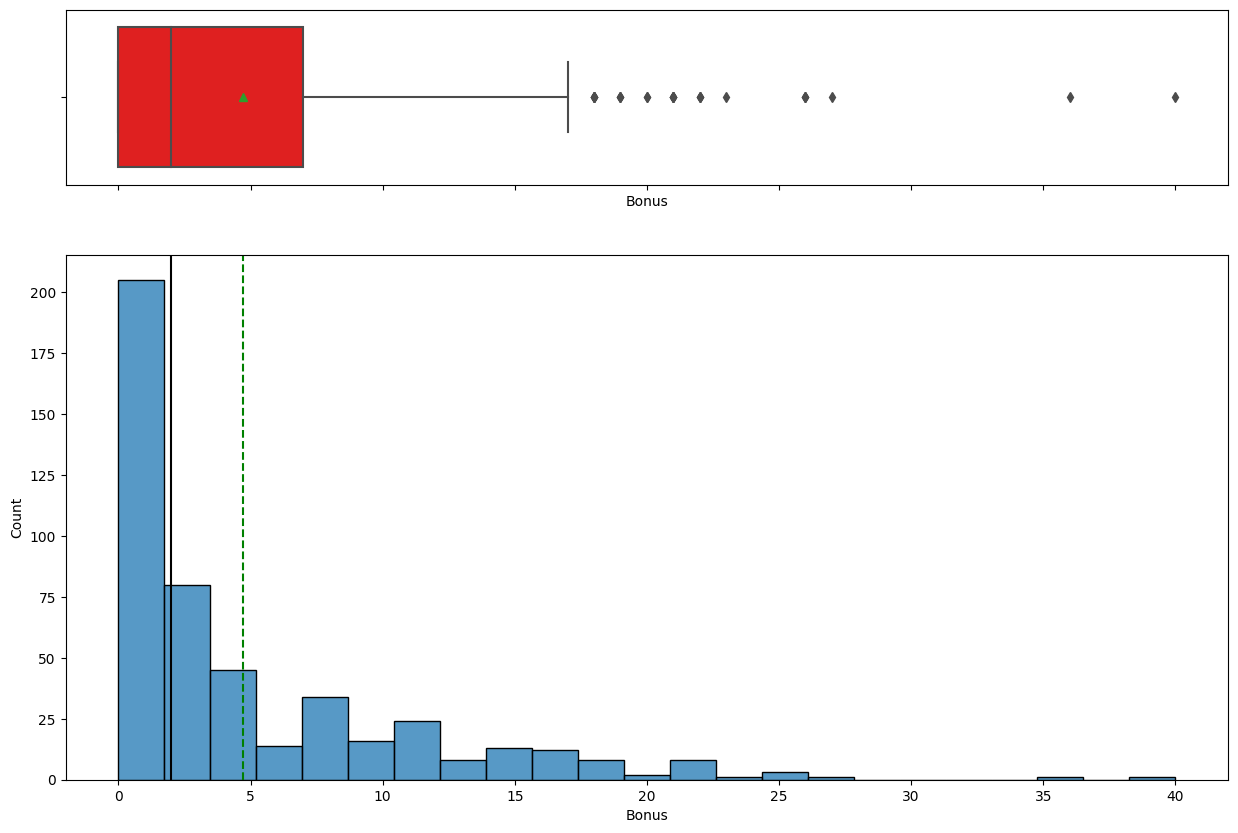

In [ ]:
hist_boxplot(df.Bonus)

### Observation:
* The distribution is right-skewed.
* Very few players received more than 20 bonus points last season.

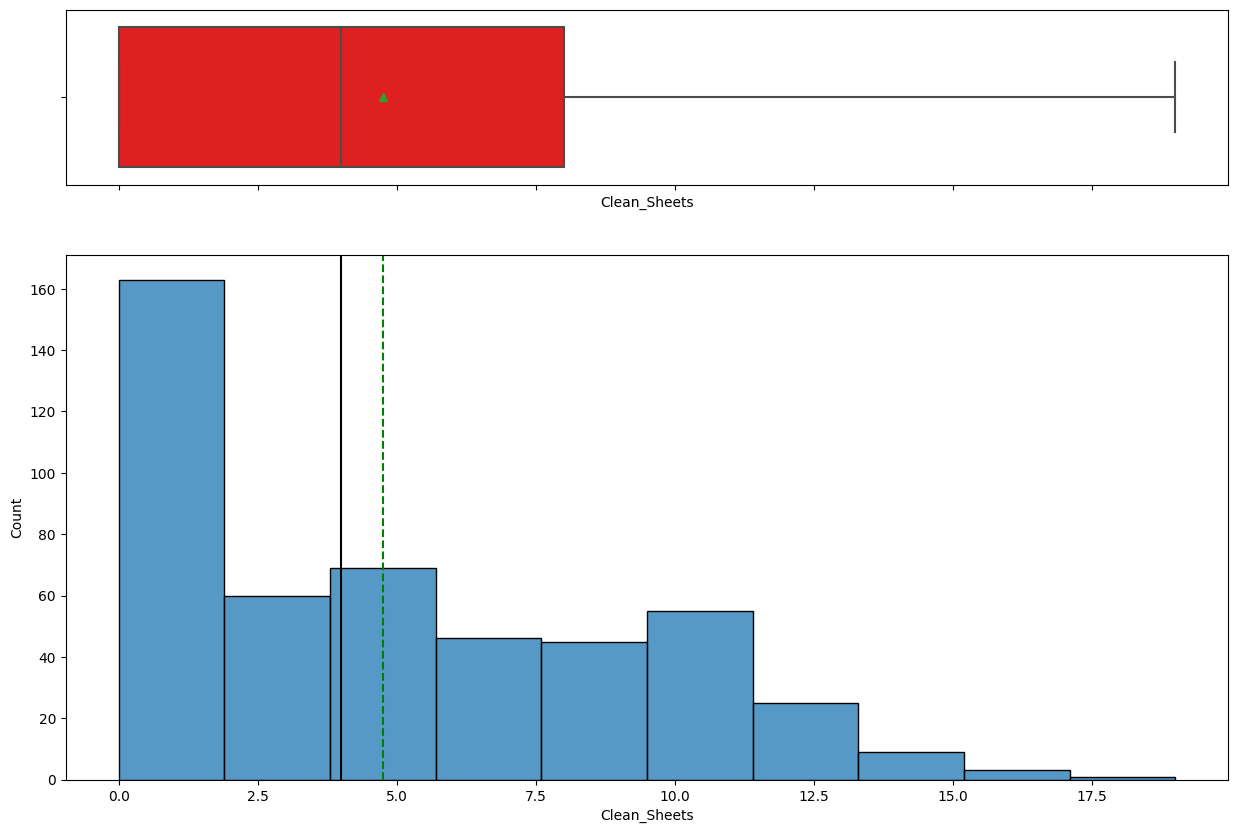

In [ ]:
hist_boxplot(df.Clean_Sheets)

### Observation:
* The distribution for clean sheets is slightly rignt-skewed.
* 50% of the players have kept 4 or less clean sheets.

Arsenal                     30
Crystal Palace              30
Leeds United                29
West Ham United             29
Tottenham Hotspurs          29
Newcastle United            29
Leicester City              29
Manchester United           28
Chelsea                     28
Brighton and Hove Albion    28
Everton                     27
Liverpool                   27
Manchester City             27
Southampton                 27
Burnley                     27
Aston Villa                 26
Wolverhampton Wanderers     26
Name: Club, dtype: int64


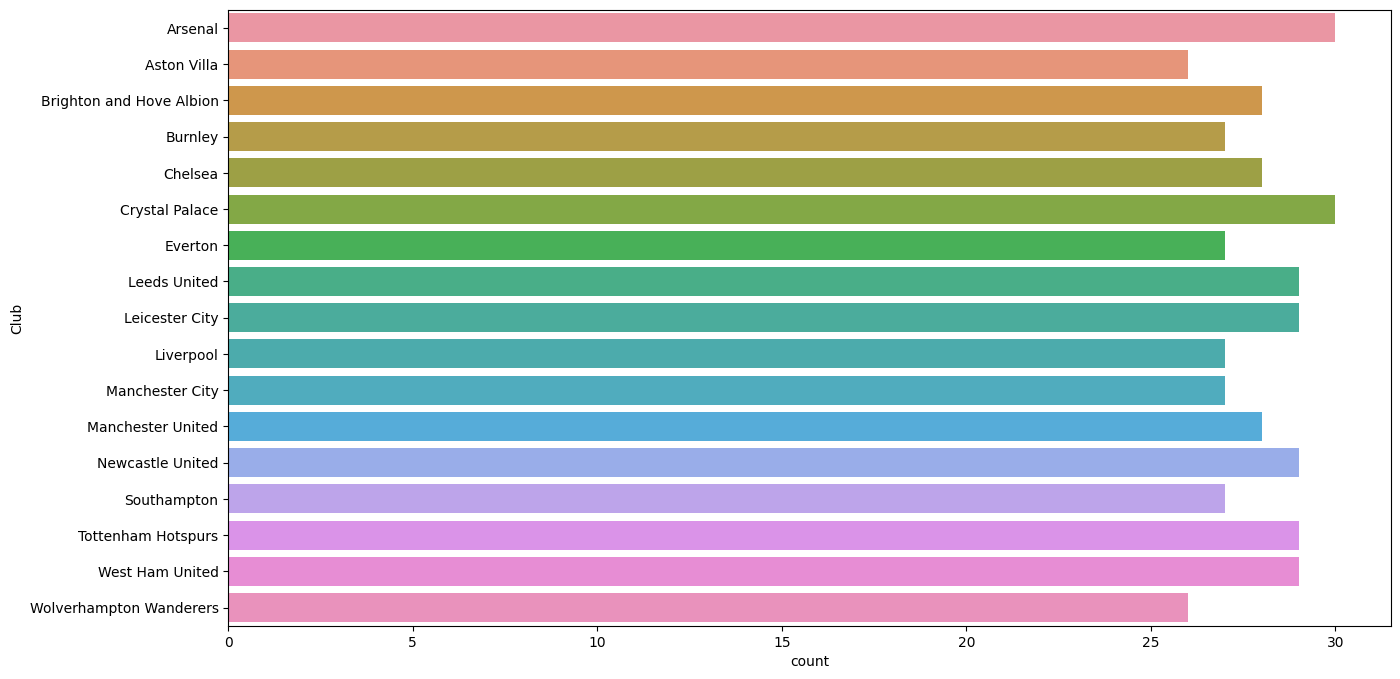

In [ ]:
# Labeled Barplots
plt.figure(figsize =(15,8))
sns.countplot(data = df, y = 'Club')
print(df.Club.value_counts())

### Observation:
* The number of players in each club is almost uniformly distributed.
* All clubs have at least 26 players.

Midfielder    195
Defender      172
Forward        64
Goalkeeper     45
Name: Position, dtype: int64


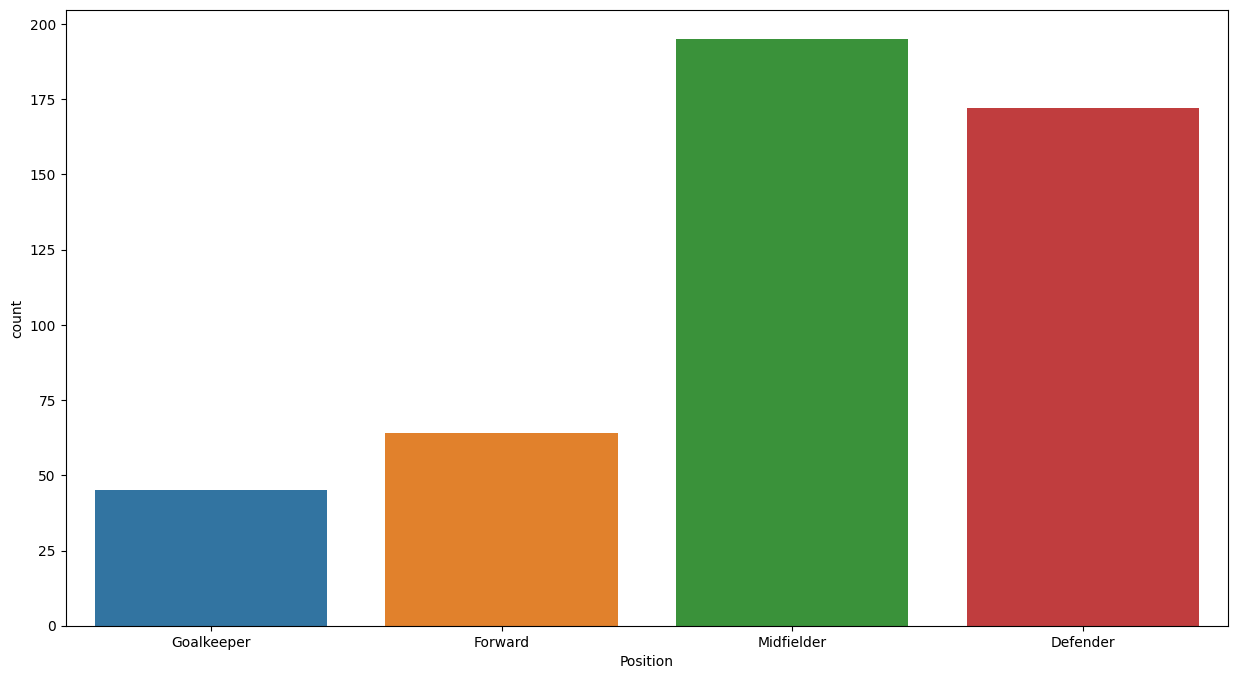

In [ ]:
plt.figure(figsize =(15,8))
sns.countplot(data = df, x = 'Position',  )
print(df.Position.value_counts())

### Observation:
* There are significantly more midfielders and defenders than goalkeepers and forwrads.
  * Each squad is limited to 4 goalkeepers so this makes sense.
  * Most teams also have approximately 3 forwards so the low number of forwards also makes sense.

## Bivariate Analysis

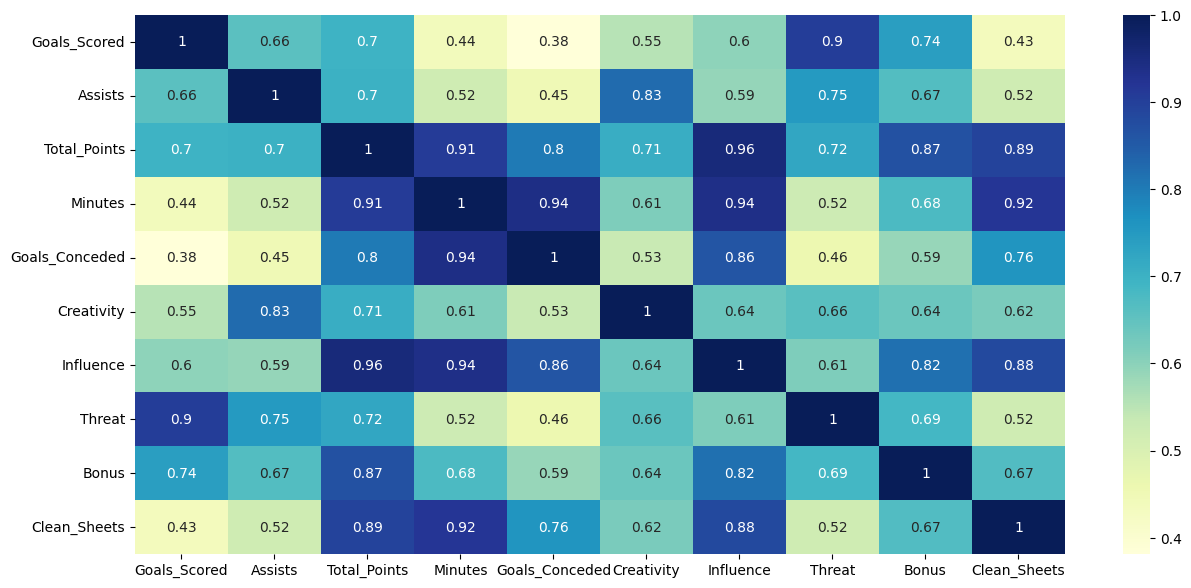

In [ ]:
corr = df.corr()
plt.figure(figsize=(15,7))
sns.heatmap(corr, annot = True, cmap="YlGnBu")
plt.show()

### Observation:
Manay variables show a high correlation with each other.
* Total points has a positive correlation with all other variables.
* Influence and total minutes played have the highest correlation to total points.
* There is a significant correlation between the number of goals and the total points, as is the case with assists and total points.
* Threat has a significant correlation between the number of goals scored.
* Influence is highly correlated with the total fantasy points scored and the number of minutes played by a player.
  * This makes sense as these players have a higher impact on the game's outcome, so they tend to play for long each game abd score  more fantasy points.
* Influence can also have a negative effect as its impact aslo increases with the rising number of goals conceded.

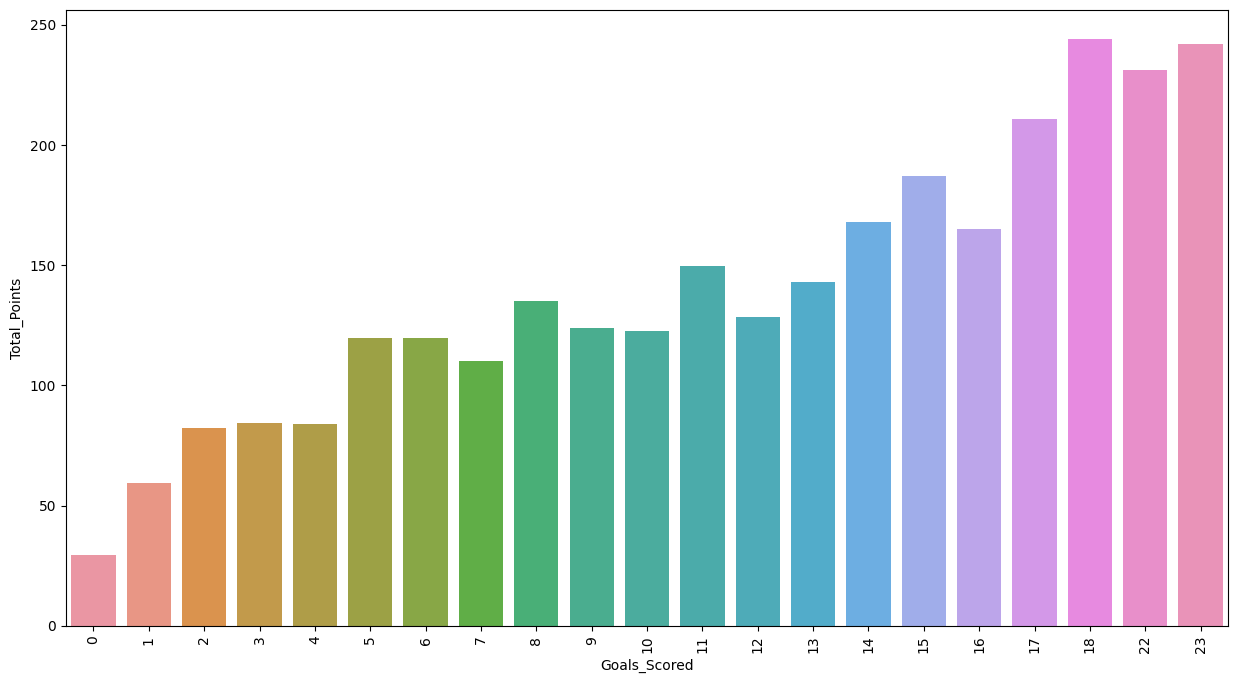

In [ ]:
#Total Points by Goals scored
plt.figure(figsize=(15, 8))
sns.barplot(x = 'Goals_Scored', y = 'Total_Points', data = df,  ci = False)
plt.xticks(rotation = 90)
plt.show()

### Observation:
* The more goals a player scores the higher their total points.


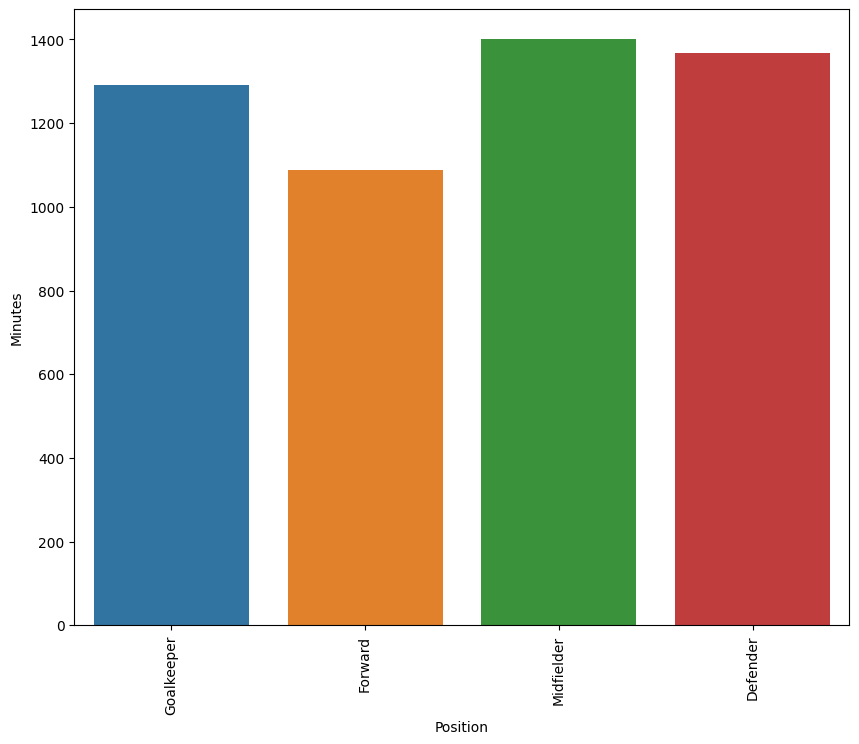

In [ ]:
#Minutes by position
plt.figure(figsize=(10,8))
sns.barplot(x='Position', y='Minutes', data = df,  ci = False)
plt.xticks(rotation = 90)
plt.show()

### Observation:
* Midfielders and defenders played more minutes thans forwards and goalkeepers.

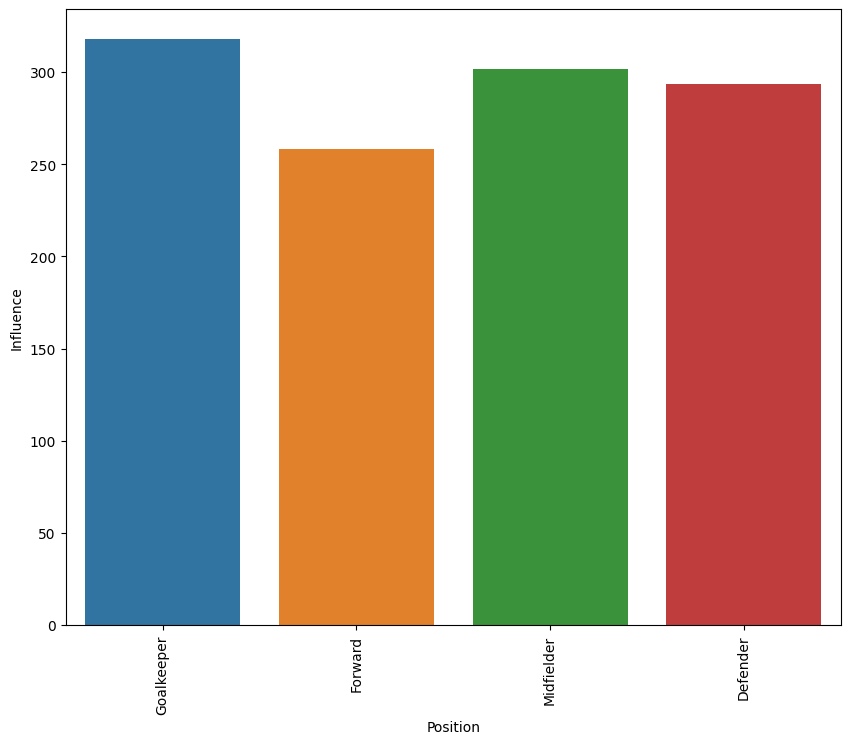

In [ ]:
# influence by position
plt.figure(figsize=(10,8))
sns.barplot(x='Position', y='Influence', data = df,  ci = False)
plt.xticks(rotation = 90)
plt.show()

### Observation:
* Surprisingly forwards have the lowest influence on matches.
* Goalkeepers influence the games much more than other positions.

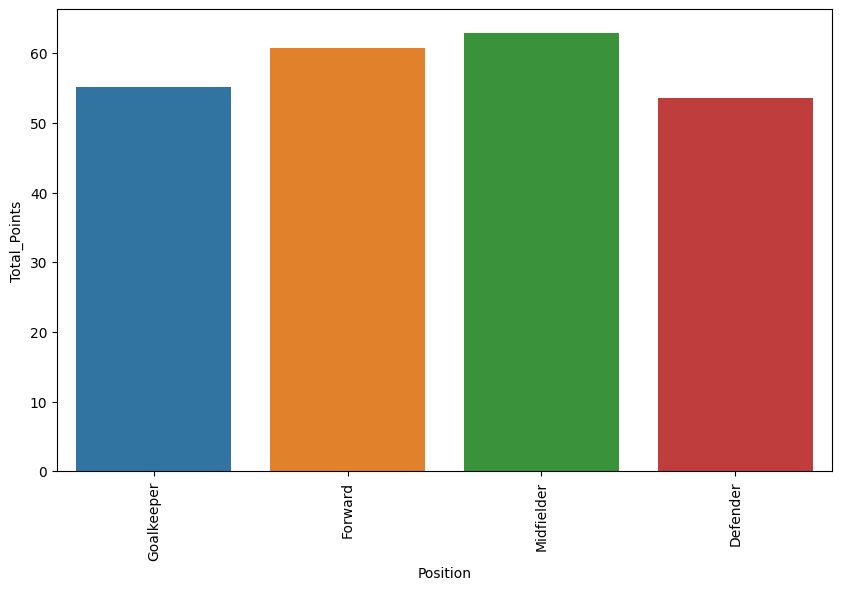

In [ ]:
# position by total points
plt.figure(figsize=(10,6))
sns.barplot(x = 'Position', y = 'Total_Points', data = df,  ci = False)
plt.xticks(rotation = 90)
plt.show()

In [ ]:
df.columns

Index(['Player_Name', 'Club', 'Position', 'Goals_Scored', 'Assists',
       'Total_Points', 'Minutes', 'Goals_Conceded', 'Creativity', 'Influence',
       'Threat', 'Bonus', 'Clean_Sheets'],
      dtype='object')

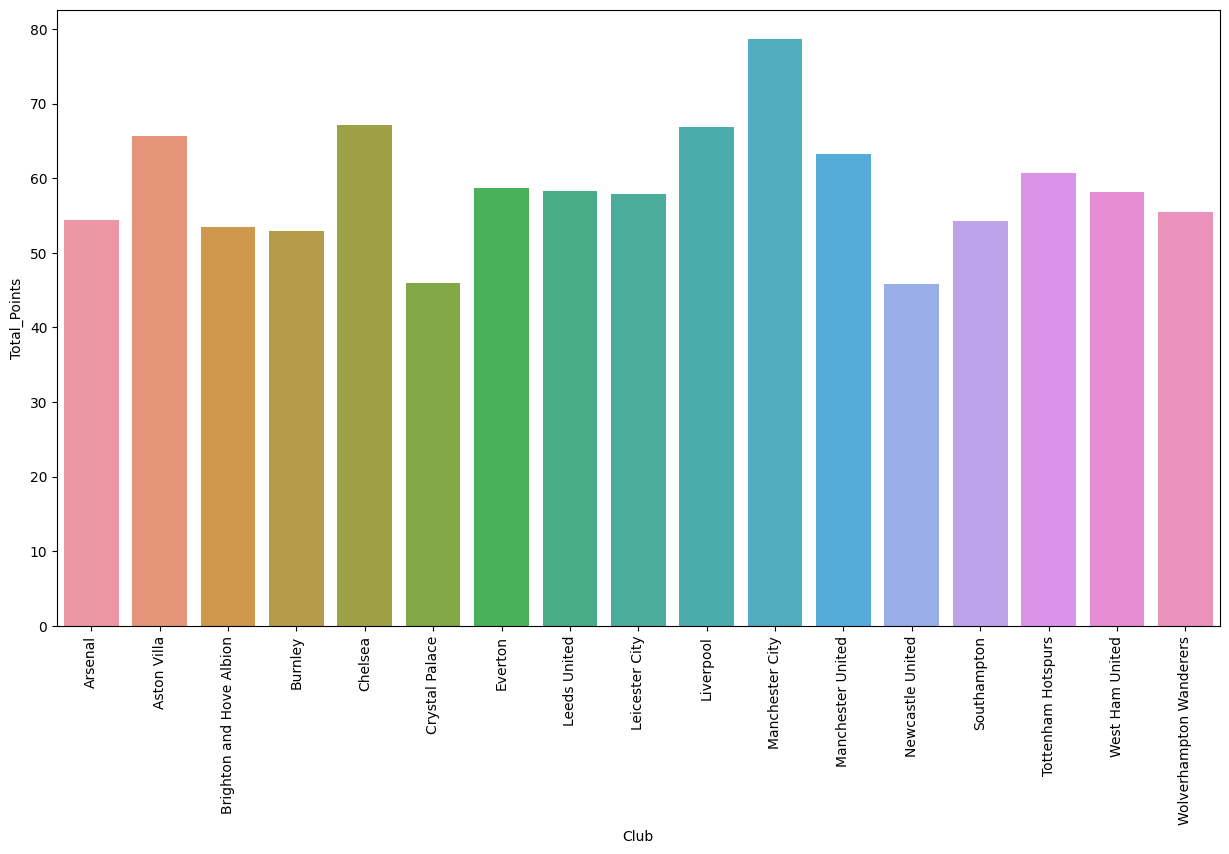

In [ ]:
# position by total points
plt.figure(figsize=(15,8))
sns.barplot(x = 'Club', y = 'Total_Points', data = df, ci = False)
plt.xticks(rotation = 90)
plt.show()

In [ ]:
top_players = df.groupby('Total_Points').max().sort_values(by = 'Total_Points', ascending = False).head(10)
top_players

,Player_Name,Club,Position,Goals_Scored,Assists,Minutes,Goals_Conceded,Creativity,Influence,Threat,Bonus,Clean_Sheets
Total_Points,,,,,,,,,,,,
244,Bruno Fernandes,Manchester United,Midfielder,18,14,3101,36,1414.9,1292.6,1253,36,13
242,Harry Kane,Tottenham Hotspurs,Forward,23,14,3083,39,659.1,1318.2,1585,40,12
231,Mohamed Salah,Liverpool,Midfielder,22,6,3077,41,825.7,1056.0,1980,21,11
228,Heung-Min Son,Tottenham Hotspurs,Midfielder,17,11,3119,36,1049.9,1052.2,1046,26,13
194,Patrick Bamford,Leeds United,Forward,17,11,3052,50,371.0,867.2,1512,26,10
187,Jamie Vardy,Leicester City,Forward,15,14,2838,44,356.6,819.2,1306,23,8
186,Emiliano Martinez,Aston Villa,Goalkeeper,0,0,3420,46,20.0,1067.2,0,27,15
176,Sadio Mane,Liverpool,Midfielder,11,11,2808,28,809.7,808.8,1535,14,12
174,Marcus Rashford,Manchester United,Midfielder,11,11,2917,39,682.1,793.2,1127,9,12


In [ ]:
# Top 5 players in each position
p1 = df.loc[df[df['Position'] == 'Forward']['Total_Points'].sort_values(ascending = False).index[0:5], ['Player_Name', 'Club', 'Position', 'Total_Points']]

p2 = df.loc[df[df['Position'] == 'Midfielder']['Total_Points'].sort_values(ascending = False).index[0:5], ['Player_Name', 'Club', 'Position', 'Total_Points']]

p3 = df.loc[df[df['Position'] == 'Defender']['Total_Points'].sort_values(ascending = False).index[0:5], ['Player_Name', 'Club', 'Position', 'Total_Points']]

p4 = df.loc[df[df['Position'] == 'Goalkeeper']['Total_Points'].sort_values(ascending = False).index[0:5], ['Player_Name', 'Club', 'Position', 'Total_Points']]

top_5 = pd.concat([p1, p2, p3, p4], axis = 0)
top_5

,Player_Name,Club,Position,Total_Points
403,Harry Kane,Tottenham Hotspurs,Forward,242
219,Patrick Bamford,Leeds United,Forward,194
238,Jamie Vardy,Leicester City,Forward,187
51,Ollie Watkins,Aston Villa,Forward,168
177,Dominic Calvert-Lewin,Everton,Forward,165
315,Bruno Fernandes,Manchester United,Midfielder,244
269,Mohamed Salah,Liverpool,Midfielder,231
405,Heung-Min Son,Tottenham Hotspurs,Midfielder,228
276,Sadio Mane,Liverpool,Midfielder,176
326,Marcus Rashford,Manchester United,Midfielder,174


#### Outlier Treatment

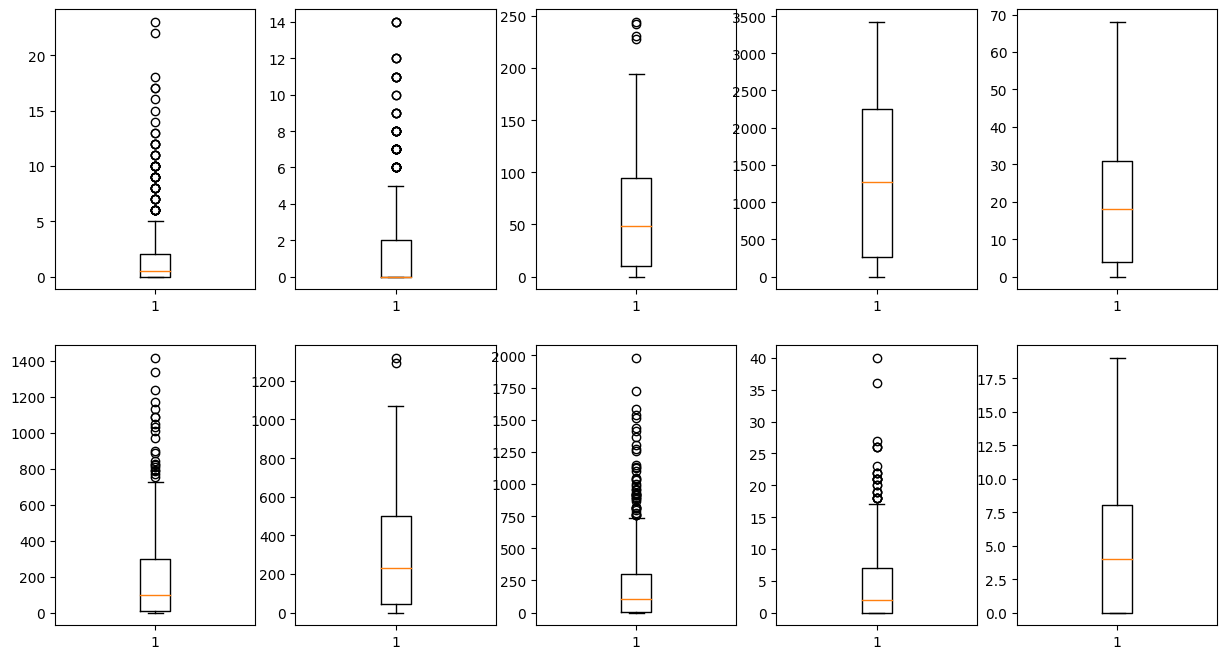

In [ ]:
numerical = df.select_dtypes(np.number).columns.values

plt.figure(figsize = (15,  8))
for i, j in enumerate(numerical):
  plt.subplot(2, 5, i+1)
  plt.boxplot(df[j])

## Scaling

In [ ]:
data = df.copy(deep = True)
data = data.drop(['Player_Name','Club', 'Position'], axis =1)

In [ ]:
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)

In [ ]:
scaled_data_copy = scaled_data.copy(deep = True)

In [ ]:
n = scaled_data.shape[1]

pca = PCA(n_components = n, random_state = 1)
data_pca1 = pd.DataFrame(pca.fit_transform(scaled_data))

exp_var = pca.explained_variance_ratio_

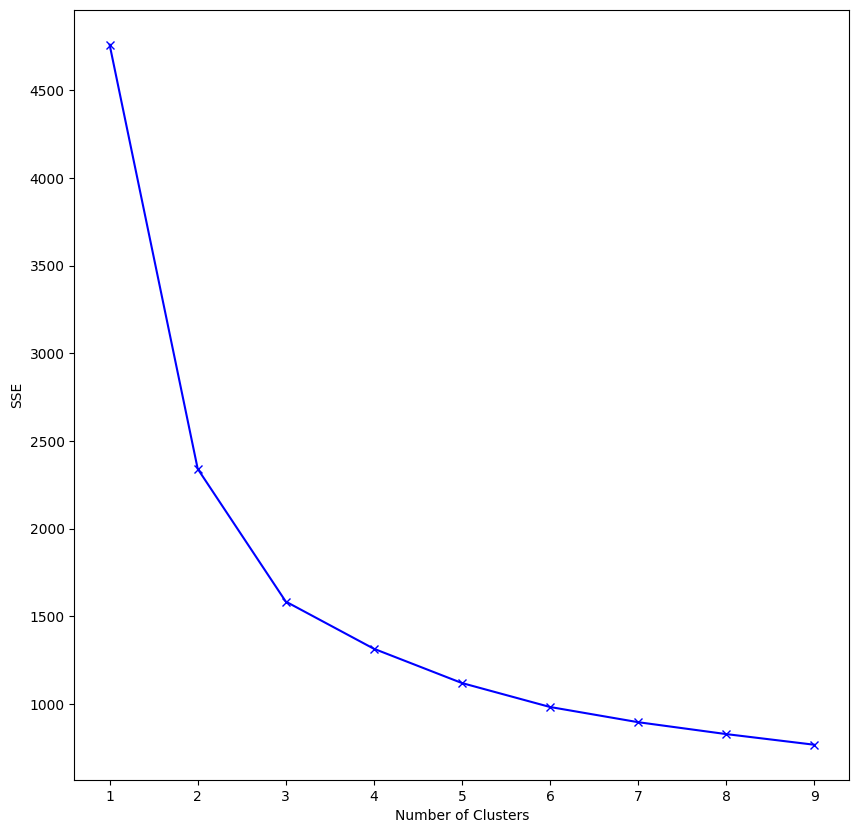

In [ ]:
sse = {}

for k in range(1,10):
  kmeans = KMeans(n_clusters=k, random_state = 1).fit(scaled_data)
  sse[k] = kmeans.inertia_


plt.figure(figsize=(10,10))
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()


### Observation:
* It's not clear what the optimal number of clusters is but 4 seems like the best choice.
* The silhouette score will be used tk confirm if the
optimal number of clusters is k=4

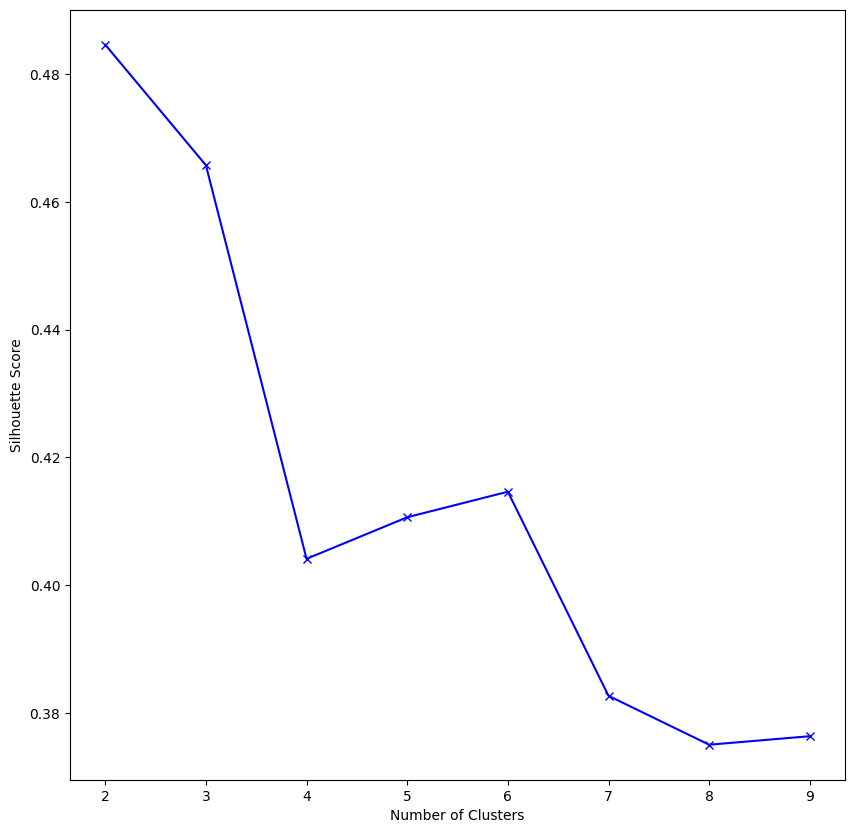

In [ ]:
shc = {}

for k in range (2, 10):
  kMeans = KMeans(n_clusters = k, random_state = 1).fit(scaled_data)
  labels = kMeans.predict(scaled_data)
  shc[k] = silhouette_score(scaled_data, labels)

plt.figure(figsize=(10,10))
plt.plot(list(shc.keys()), list(shc.values()), 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

### Observation:
* The Silhouette Score method confirms that the optimal number of clusters is k = 4.

In [ ]:
kmeans = KMeans(n_clusters=4, random_state = 1)
kmeans.fit(scaled_data)

scaled_data_copy['KMeans_Label'] = kmeans.predict(scaled_data)
df['KMeans_Label'] = kmeans.predict(scaled_data)

In [ ]:
df.KMeans_Label.value_counts()

3    188
0    128
1     99
2     61
Name: KMeans_Label, dtype: int64

### Observation:
* With k=4, the clusters seem to be skewed and uneven.

In [ ]:
mean = df.groupby('KMeans_Label').mean()
median = df.groupby('KMeans_Label').median()
df_Kmeans = pd.concat([mean, median], axis = 0)
df_Kmeans.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_3 Mean',
                   'group_0 Median', 'group_1 Median', 'group_2 Median', 'group_3 Median']
df_Kmeans.T

,group_0 Mean,group_1 Mean,group_2 Mean,group_3 Mean,group_0 Median,group_1 Median,group_2 Median,group_3 Median
Goals_Scored,1.460938,1.363636,9.147541,0.148936,1.0,1.0,9.0,0.0
Assists,1.601562,1.878788,6.639344,0.202128,1.0,1.0,6.0,0.0
Total_Points,55.648438,103.525253,141.557377,9.824468,52.5,100.0,134.0,4.0
Minutes,1389.453125,2670.555556,2446.704918,238.750000,1373.5,2598.0,2554.0,101.5
Goals_Conceded,20.554688,37.525253,33.344262,3.930851,20.0,37.0,33.0,2.0
Creativity,187.653125,265.671717,617.495082,28.171809,164.4,261.4,545.8,4.6
Influence,270.037500,579.185859,659.324590,43.164894,266.2,549.2,595.8,17.0
Threat,218.117188,199.636364,880.540984,30.244681,166.0,189.0,866.0,4.0
Bonus,3.312500,7.676768,16.147541,0.409574,3.0,7.0,15.0,0.0
Clean_Sheets,4.687500,10.020202,9.213115,0.558511,4.0,10.0,10.0,0.0


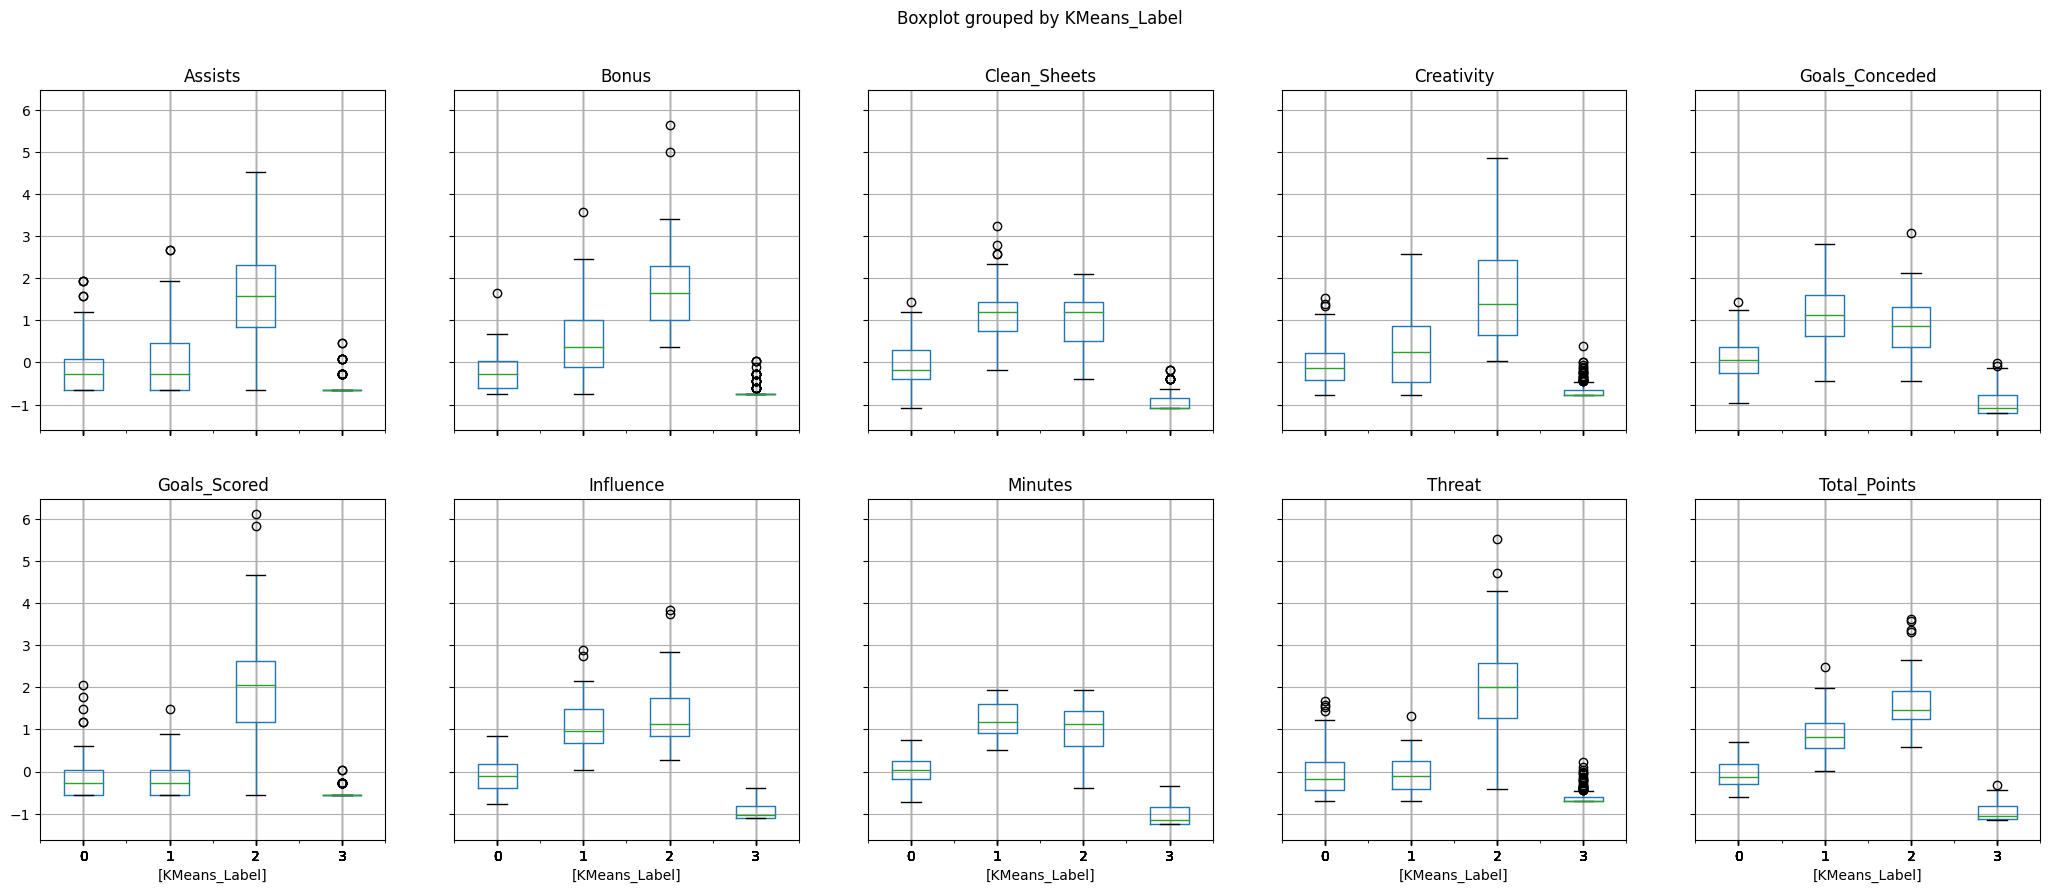

In [ ]:
scaled_data_copy.boxplot(by = 'KMeans_Label', layout = (2,5), figsize=(25,10))
plt.show()

### Observation:
* Group 0
  * Low performing players. There are 128 players in this cluster.
  * Most of these players have a few goals and assists, and the total points from the previous fantasy season is low.
  * Most of the players in this cluster has moderate game time, low creativity score, low influence score, moderate threat score, and low bonus scores.
* Group 1
  * There are 99 players in this cluster.
  * Most of the players have a few goals and assists, and moderate total points from the previous fantasy season.
  * Most of the players have high game time, moderate creativity score, high influence score, low threat score, and a moderate bonus score.
* Group 2
  * There are 61 players in this cluster.
  * Most of the players have a lot of goals and assists, and the total points from the previous fantasy season is high.
  * Most of the players had a high game time, creativity score, influence score, threat score, and bonus score
* Group 3
  * There are 188 players in this cluster.
  * Most of the players did not record a goal and assist, and the total points for the previous fantasy season is low.
  * These players had a low game time, creativity score, influence score, threat score, and bonus score.

In [ ]:
# Players within each cluster
df.head()

,Player_Name,Club,Position,Goals_Scored,Assists,Total_Points,Minutes,Goals_Conceded,Creativity,Influence,Threat,Bonus,Clean_Sheets,KMeans_Label
0,Alex Runnarsson,Arsenal,Goalkeeper,0,0,1,15,0,0.0,16.6,0,0,0,3
1,Alexandre Lacazette,Arsenal,Forward,13,3,129,1916,21,307.4,602.4,797,21,7,2
2,Bernd Leno,Arsenal,Goalkeeper,0,0,131,3131,37,0.0,702.2,2,11,11,1
3,Bukayo Saka,Arsenal,Midfielder,5,5,114,2554,31,650.6,493.0,984,8,8,2
4,Calum Chambers,Arsenal,Defender,0,3,36,751,10,169.4,171.8,77,3,2,0


In [ ]:
# Assigning each player a cluster profile